In [77]:
from skimage.io import imread
import numpy as np
from scipy.fftpack import dct, idct
from matplotlib import pyplot as plt
import random
import math
from google.colab import drive

In [78]:
drive.mount('/content/drive')
rootfolder = '/content/drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Definition of dct2 and idct2 (they are not builtin functions)

In [79]:
def dct2(s):
    return dct(dct(s.T, norm='ortho').T, norm='ortho')


def idct2(x):
    return idct(idct(x.T, norm='ortho').T, norm='ortho')

Useful function for plot the 2D DCT dictionary

In [80]:
def get_dictionary_img(D):
    M = D.shape[0]
    p = int(round(np.sqrt(M)))
    bound = 2
    img = np.ones((p*p+bound*(p-1), p*p+bound*(p-1)))
    for i in range(M):
        m = np.mod(i, p)
        n = int((i-m)/p)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Set the patch size

In [81]:
p = 8 # patch size
M = p ** 2 # number of elements in the patch


Load the image and extract a patch

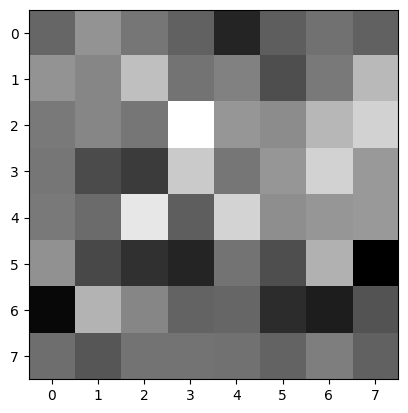

In [82]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255 # bring the image in [0,1] range

# extract a patch from the image

n1= random.randrange(0,256-p)
s_block = img[n1:n1+p,n1:n1+p]

# unroll the patch
s = s_block.reshape(p**2,1)

# show the patch
plt.imshow(s_block, cmap='gray')

Compute the 2D DCT matrix (M x M)
---------------------------------
Build the matrix corresponding to the 2D DCT using the idct2 function

In [83]:
D = np.zeros((M, M))
cnt = 0
for i in range(p):
  for j in range(p):
    a = np.zeros((p,p)) 
    a[i,j] = 1 
    D[:, cnt] = idct2(a).flatten() 
    cnt = cnt + 1


Verify that D is orthonormal

In [84]:
is_D_orth = np.all(abs(D@D.T - np.identity(M)) < 0.0001)
D@D.T
print(f'DCT dictionary is orthogonal: {is_D_orth}')

DCT dictionary is orthogonal: True


All the atoms in D can be seen as patch. Let's plot them!

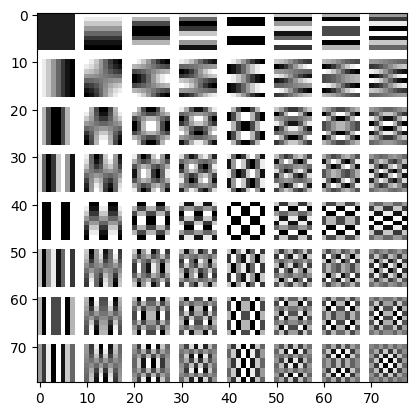

In [85]:
D_img = get_dictionary_img(D)
plt.imshow(D_img, cmap='gray')

Compute the representation w.r.t. the 2D DCT matrix

In [86]:
x = D.T@s
x= x.reshape((p,p))

Separable 2D DCT
----------------
Build the 1D DCT matrix

In [87]:
D1 = np.zeros((p, p))
for i in range(p):
    a= np.zeros(p)
    a[i]=1
    D1[:, i] = idct(a, norm='ortho')

Compute the dct2 exploiting the separability

In [88]:
x_block = D1.T@s_block@D1

Check if the coefficient computed using the two methods are equal

In [89]:
is_coeff_equal = np.all(abs(x - x_block < 0.001))
print(f'The two vectors of coefficients are the same: {is_coeff_equal}')


The two vectors of coefficients are the same: True


JPEG Compression
----------------
Set the threshold for the compression

In [90]:
threshold = 0.1

Initialize the compressed image and the number of nonzero coefficients

In [91]:
img_comp = np.zeros_like(img)
nnz_coeff = 0

Process the image patchwize

In [92]:
for i in range(0, img.shape[0], p):
    for j in range(0, img.shape[1], p):
        # extract the patch
        # unroll the patch
        s = img[i:i+p,j:j+p]

        # compute the representation w.r.t. the 2D DCT dictionary
        x = (D1.T@s)@D1

        # perform the hard thresholding (do not perform HT on the DC!)
        x_HT = x.copy()
        x_HT[np.abs(x_HT)<=threshold] = 0
        x_HT[0,0]=x[0,0]
        
        # reconstruct the patch
        s_hat = idct2(x_HT)

        # put the compressed patch into the compressed image
        img_comp[i:i+p, j:j+p] = s_hat

        # update the total number of nonzero coefficient
        nnz_coeff += np.count_nonzero(x_HT)
  

Compute the PSNR

In [93]:
mse = ((img-img_comp)**2).mean()
psnr= 10*math.log10(1/mse)

Compute the compression ratio

In [94]:
comp_ratio = nnz_coeff/(256*256)

Show the original image and the compressed one:

Text(0.5, 1.0, 'Compressed Image,\nPSNR = 31.94, compression_ratio = 0.10')

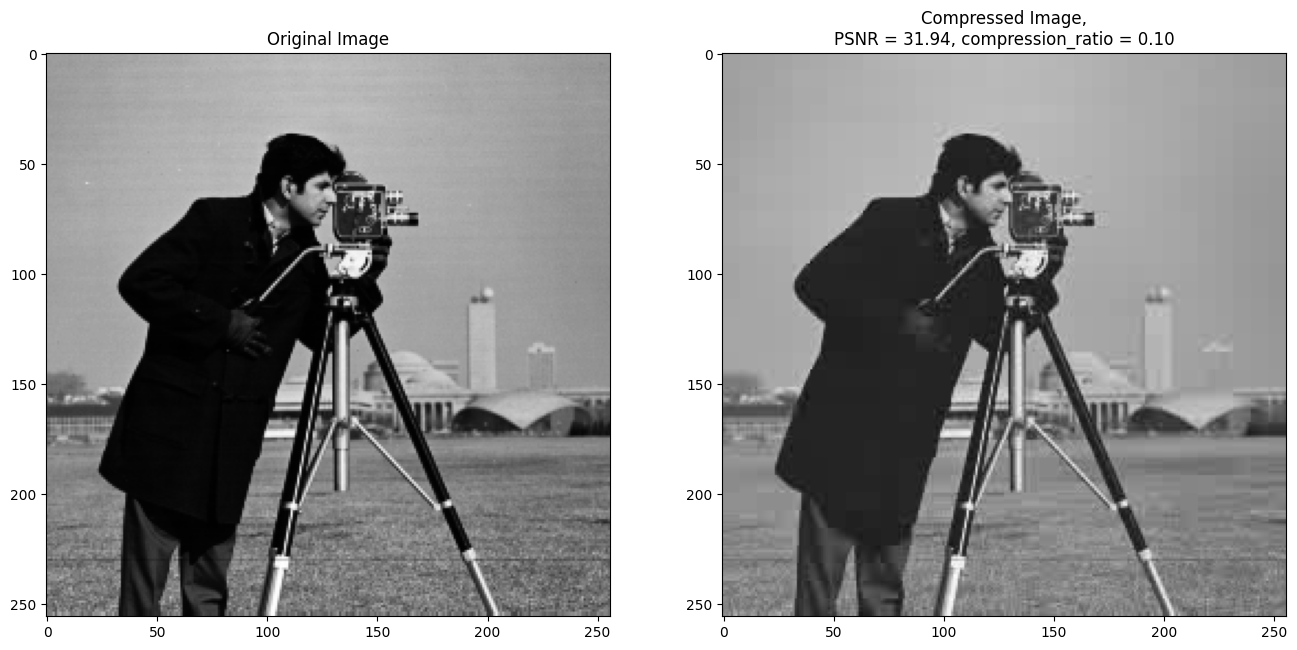

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(16, 12))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(img_comp, cmap='gray')
ax[1].set_title(f'Compressed Image,\nPSNR = {psnr:.2f}, compression_ratio = {comp_ratio:.2f}')
